In [1]:
import numpy as np
import numpy as np
from scipy.interpolate import interp1d, interp2d, RectBivariateSpline, LinearNDInterpolator, NearestNDInterpolator
from scipy.integrate import odeint
import concurrent.futures, itertools
import matplotlib.pyplot as plt
import pickle, tqdm, functools
import sys
sys.path.append('/home/fverdian/class/soundspeed-scripts/kernels-fullnum/numerical-integrals')
from num_kernels import NumKernels, PLfromClass

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
})


In [2]:
with open('/home/fverdian/class/soundspeed-scripts/1loop/Pk-lin-int.pkl', 'rb') as f:
    Plin_int = pickle.load(f)
fact=(2*np.pi)**3

fx=0.1
t_ini = -6
fullt=np.linspace(t_ini,10, 200)
teval=0
kref=0.45
supprshift=5
nk = NumKernels(fx=fx, kref=kref, fullt=fullt, rtol=0.0001)

----
plot the $P_{22}$ integrand for delta Theta

In [9]:
kEv= 0.2
qlist=np.logspace(-3,np.log10(1),30)
PdcTclist=[];PdcTxlist=[]
mup=1.
for q in qlist:
    # print(f'q={qp:.1e}', end='\r', flush=True)
    g_k=nk.g_an(-2*np.log(kEv/kref));g_q=nk.g_an(-2*np.log(q/kref));h_k=nk.h_an(-2*np.log(kEv/kref))

    F3_cval, G3_cval, _, G3_xval=nk.solve_F3([kEv,q,mup])
    P13dcTc=3*q*q*(F3_cval*nk.g_c_int(-2*np.log(kEv/kref))+G3_cval)*Plin_int(q)*Plin_int(kEv)
    P13dcTx=3*q*q*(nk.F3_0(kEv,q,mup)*h_k+G3_xval)*Plin_int(q)*Plin_int(kEv)

    P13dcTc_EdS=3*q*q*(nk.F3_0(kEv,q,mup)+ nk.G3_0(kEv,q,mup))*nk.g_c_int(-2*np.log(kEv/kref))*Plin_int(q)*Plin_int(kEv)
    P13dcTx_EdS=3*q*q*(nk.F3_0(kEv,q,mup) + nk.G3_0(kEv,q,mup)*g_q*g_q)*h_k*Plin_int(q)*Plin_int(kEv)

    print(F3_cval*nk.g_c_int(-2*np.log(kEv/kref))+G3_cval-(nk.F3_0(kEv,q,mup)+ nk.G3_0(kEv,q,mup))*nk.g_c_int(-2*np.log(kEv/kref)))

    kMq = np.sqrt(kEv*kEv + q*q - 2*kEv*q*mup)
    kPq = np.sqrt(kEv*kEv + q*q + 2*kEv*q*mup)
    P22dcTc=0; P22dcTx=0;P22dcTc_EdS=0; P22dcTx_EdS=0
    if kMq>q:
        cT12 = (kEv*mup-q)/kMq
        F2_cval,G_cval,F2_xval,G2_xval=nk.solve_F2([q,kMq,cT12])
        P22dcTc+=2*q*q*(F2_cval*G_cval)*Plin_int(q)*Plin_int(kMq)
        P22dcTx+=2*q*q*(G2_xval*nk.F2_0(kEv,q,mup))*Plin_int(q)*Plin_int(kMq)

        P22dcTc_EdS+=2*q*q*(nk.F2_0(kEv,q,mup)*nk.G2_0(kEv,q,mup))*nk.g_c_int(-2*np.log(kEv/kref))*Plin_int(q)*Plin_int(kMq)
        P22dcTx_EdS+=2*q*q*(nk.F2_0(kEv,q,mup)*nk.G2_0(kEv,q,mup)*h_k/g_k*g_q*nk.g_an(-2*np.log(kMq/kref)))*Plin_int(q)*Plin_int(kMq)

    if kPq>q:
        cT12 = -(kEv*mup+q)/kPq
        F2_cval,G_cval,F2_xval,G2_xval=nk.solve_F2([q,kPq,cT12])
        P22dcTc+=2*q*q*(F2_cval*G_cval)*Plin_int(q)*Plin_int(kPq)
        P22dcTx+=2*q*q*(G2_xval*nk.F2_0(kEv,q,-mup))*Plin_int(q)*Plin_int(kPq)

        P22dcTc_EdS+=2*q*q*(nk.F2_0(kEv,q,-mup)*nk.G2_0(kEv,q,-mup))*nk.g_c_int(-2*np.log(kEv/kref))*Plin_int(q)*Plin_int(kPq)
        P22dcTx_EdS+=2*q*q*(nk.F2_0(kEv,q,-mup)*nk.G2_0(kEv,q,-mup)*h_k/g_k*g_q*nk.g_an(-2*np.log(kPq/kref)))*Plin_int(q)*Plin_int(kPq)

    intf=4*q*np.pi/fact
    
    PdcTclist.append([P13dcTc*intf,P22dcTc*intf,P13dcTc_EdS*intf,P22dcTc_EdS*intf])
    PdcTxlist.append([P13dcTx*intf,P22dcTx*intf,P13dcTx_EdS*intf,P22dcTx_EdS*intf])

-15.203048819214018
-9.563291115678112
-5.9569527564899545
-3.5989643182133477
-2.281323148718002
-1.4229453984305565
-0.8796835135934771
-0.5411559902472618
-0.32972553340931654
-0.20234055727027567
-0.11785222463223022
-0.0677214845600389
-0.03855566486797812
-0.019122305445350207
-0.00771952857515501
-0.0010568131281054605
0.002983024898537856
0.005029620494382936
0.005852195160490847
0.006018474150161657
0.005797036665602051
0.005312375156576232
0.004783438845053167
0.004142592493882852
0.003326234725514271
0.0024896746749104165
0.001763254842208642
0.0011955759975707941
0.0007830925900081144
0.0005042330859118122


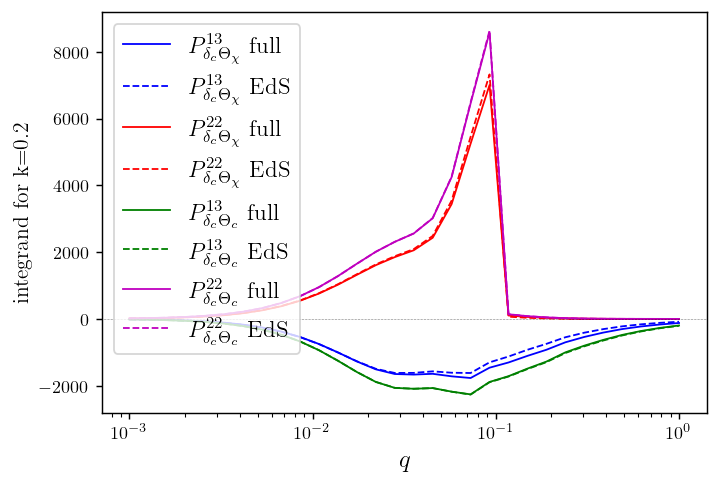

In [6]:
plt.figure(figsize=(6, 4), dpi=130)
colors=['purple','b','darkorange','red']
for i in range(1):
    dcTx13, dcTx22, dcTx13_EdS, dcTx22_EdS=np.array(PdcTxlist).T
    plt.plot(qlist,dcTx13, color='b',linestyle='-', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ full')
    plt.plot(qlist,dcTx13_EdS, color='b',linestyle='--', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ EdS')

    plt.plot(qlist,dcTx22, color='r',linestyle='-', linewidth=1., label=r'$P^{22}_{\delta_c\Theta_\chi}$ full')
    plt.plot(qlist,dcTx22_EdS, color='r',linestyle='--', linewidth=1., label=r'$P^{22}_{\delta_c\Theta_\chi}$ EdS')

    dcTc13, dcTc22, dcTc13_EdS, dcTc22_EdS=np.array(PdcTclist).T
    plt.plot(qlist,dcTc13, color='g',linestyle='-', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_c}$ full')
    plt.plot(qlist,dcTc13_EdS, color='g',linestyle='--', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_c}$ EdS')

    plt.plot(qlist,dcTc22, color='m',linestyle='-', linewidth=1., label=r'$P^{22}_{\delta_c\Theta_c}$ full')
    plt.plot(qlist,dcTc22_EdS, color='m',linestyle='--', linewidth=1., label=r'$P^{22}_{\delta_c\Theta_c}$ EdS')


plt.axhline(y=0.,linestyle=':', color='k', linewidth=0.3)
plt.ylabel(r"integrand for k=0.2", fontsize=12)

plt.xscale('log')
plt.legend(fontsize=13, loc='upper left')
plt.xlabel(r'$q$', fontsize=14)
plt.show()

now plot the sum $P^{1l}=P_{22}+P_{13}$

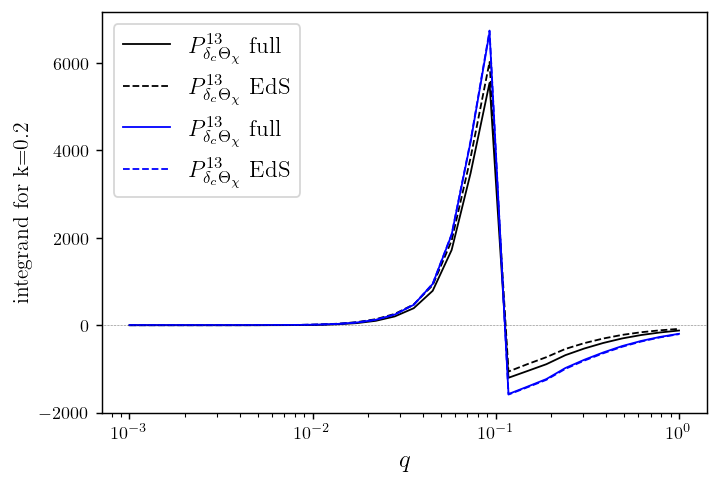

In [7]:
plt.figure(figsize=(6, 4), dpi=130)
colors=['purple','b','darkorange','red']
for i in range(1):
    dcTx13, dcTx22, dcTx13_EdS, dcTx22_EdS=np.array(PdcTxlist).T
    plt.plot(qlist,dcTx13+dcTx22, color='k',linestyle='-', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ full')
    plt.plot(qlist,dcTx13_EdS+dcTx22_EdS, color='k',linestyle='--', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ EdS')

    dcTc13, dcTc22, dcTc13_EdS, dcTc22_EdS=np.array(PdcTclist).T
    plt.plot(qlist,dcTc13+dcTc22, color='b',linestyle='-', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ full')
    plt.plot(qlist,dcTc13_EdS+dcTc22_EdS, color='b',linestyle='--', linewidth=1., label=r'$P^{13}_{\delta_c\Theta_\chi}$ EdS')



plt.axhline(y=0.,linestyle=':', color='k', linewidth=0.3)
plt.ylabel(r"integrand for k=0.2", fontsize=12)

plt.xscale('log')
plt.legend(fontsize=13, loc='upper left')
plt.xlabel(r'$q$', fontsize=14)
plt.show()

----
Plot the interesting kernels $G_c$ and $G_\chi$

In [27]:
mup=1.
G_list=[]
kerqlist = np.logspace(-3,-1,20)
kEv = 10
for qp in kerqlist:
    print(f'q={qp:.1e}', end='\r', flush=True)
    g_k=nk.g_an(-2*np.log(kEv/kref));g_q=nk.g_an(-2*np.log(qp/kref));h_k=nk.h_an(-2*np.log(kEv/kref))
    kMq = np.sqrt(kEv**2 + qp**2 - 2*kEv*qp*mup)
    cT12 = (kEv*mup-qp)/kMq
    F2c, G2c, F2x, G2x=nk.solve_F2([qp,kMq,cT12])

    F3_cval, G3c, _, G3x=nk.solve_F3([kEv,qp,mup])

    G_list.append([G2c,nk.G2_0(kEv,qp,mup),G2x,nk.G2_0(kEv,qp,mup)*g_q*nk.g_an(-2*np.log(kMq/kref)), 
                   G3c,nk.G3_0(kEv,qp,mup),G3x,nk.G3_0(kEv,qp,mup)*h_k*g_q*g_q])
G_list=np.array(G_list)

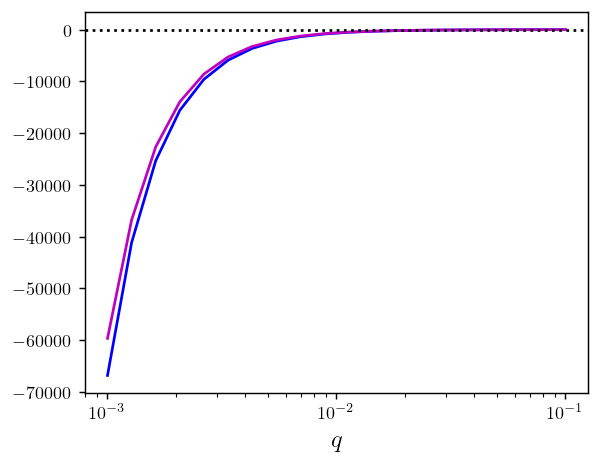

In [28]:
plt.figure(figsize=(5,3.8), dpi=130)

G2c, G2c_EdS, G2x, G2x_EdS, G3c, G3c_EdS, G3x, G3x_EdS = G_list.T


# plt.plot(kerqlist, G3c_EdS, 'b--')

plt.plot(kerqlist, G3x_EdS, 'b')
plt.plot(kerqlist, G3x, 'm')


plt.axhline(0., color='k', linestyle=':')

# plt.plot(kerqlist, np.abs(G_list[:,2]), 'b')
# plt.ylim([-5,1])
plt.xlabel(r'$q$', fontsize=14)
plt.xscale('log')
plt.show()

----
Plot the $P_{13}$ integrand for cc

In [6]:

mup=0.1 #MUST EVALUATE IT AT mu=0, otherwise the eds has a divergence
kEv= 0.1
qlist=np.logspace(-2,np.log10(7),200)
mulist=[0.,0.2,0.8,1.]
Pmulist=[]
for mup in mulist:
    P3list=[]
    print(mup)
    for qp in qlist:
        # print(f'q={qp:.1e}', end='\r', flush=True)
        F3c,_,F3x,_=nk.solve_F3([kEv,qp,mup], return_timedep=False)
        P13intgnd=6*qp*qp*F3c*Plin_int(qp)*Plin_int(kEv)
        P13intgnd_EdS=6*qp*qp*(nk.F3_0(kEv,qp,mup))*Plin_int(qp)*Plin_int(kEv)
        intf=4*qp*np.pi/fact
        P3list.append([P13intgnd*intf,P13intgnd_EdS*intf])
    Pmulist.append(np.array(P3list).T)

0.0
0.2
0.8
1.0


In [11]:

mup=0.1 #MUST EVALUATE IT AT mu=0, otherwise the eds has a divergence
kEv= 0.12
qlist=np.logspace(-3,np.log10(7),200)
mulist=[0.,0.2,0.8,1.]
Pmulist2=[]
for mup in mulist:
    P3list=[]
    print(mup)
    for qp in qlist:
        # print(f'q={qp:.1e}', end='\r', flush=True)
        F3c,_,F3x,_=nk.solve_F3([kEv,qp,mup], return_timedep=False)
        P13intgnd=6*qp*qp*F3c*Plin_int(qp)*Plin_int(kEv)
        P13intgnd_EdS=6*qp*qp*(nk.F3_0(kEv,qp,mup))*Plin_int(qp)*Plin_int(kEv)
        intf=4*qp*np.pi/fact
        P3list.append([P13intgnd*intf,P13intgnd_EdS*intf])
    Pmulist2.append(np.array(P3list).T)

0.0
0.2
0.8
1.0


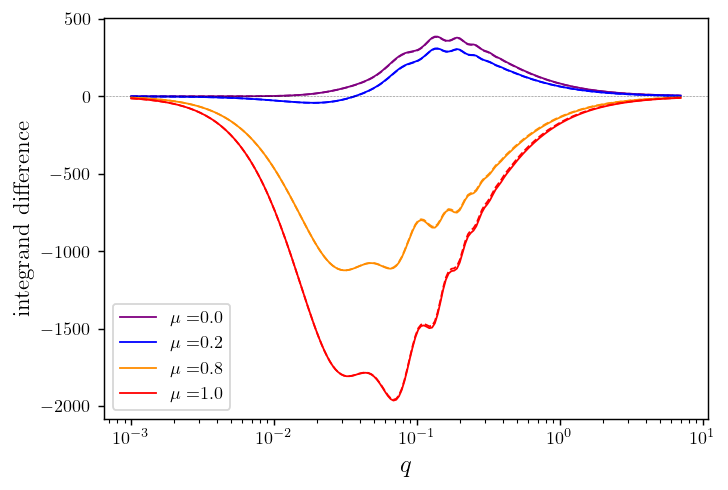

In [13]:
plt.figure(figsize=(6, 4), dpi=130)
colors=['purple','b','darkorange','red']
for i in range(len(mulist)):
    P3list=Pmulist2[i]
    plt.plot(qlist,P3list[1], color=colors[i],label=r'$\mu=$'+str(mulist[i]), linewidth=1.)
    P3list=Pmulist2[i]
    plt.plot(qlist,P3list[0], color=colors[i],linestyle='--', linewidth=1.)
plt.axhline(y=0.,linestyle=':', color='k', linewidth=0.3)
plt.ylabel(r"integrand difference", fontsize=13)

plt.xscale('log')
plt.legend()
plt.xlabel(r'$q$', fontsize=14)
plt.show()

In [3]:

mup=1. #MUST EVALUATE IT AT mu=0, otherwise the eds has a divergence
kEv= 0.12
qlist2=np.logspace(np.log10(0.05),np.log10(0.7),100)

P3list=[]
print(mup)
for qp in qlist2:
    # print(f'q={qp:.1e}', end='\r', flush=True)
    F3c,_,F3x,_=nk.solve_F3([kEv,qp,mup], return_timedep=False)
    P13intgnd=6*qp*qp*F3c*Plin_int(qp)*Plin_int(kEv)
    P13intgnd_EdS=6*qp*qp*(nk.F3_0(kEv,qp,mup))*Plin_int(qp)*Plin_int(kEv)
    intf=4*qp*np.pi/fact
    P3list.append([P13intgnd*intf,P13intgnd_EdS*intf])
P3list=np.array(P3list).T

1.0


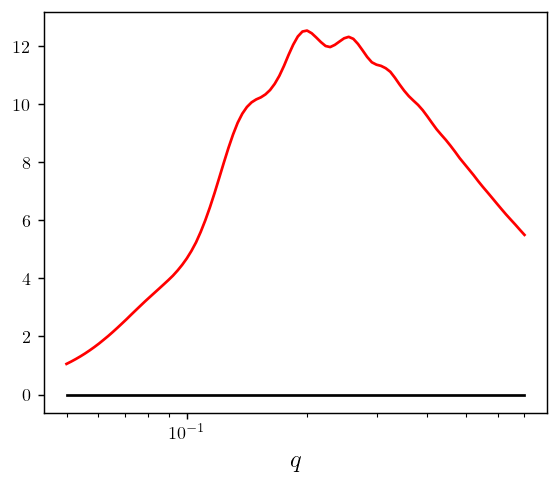

In [4]:
plt.figure(figsize=(5, 4), dpi=130)
plt.plot(qlist2,P3list[0]-P3list[1], color='r')
plt.plot(qlist2,qlist2*0, color='k')

plt.xscale('log')
plt.xlabel(r'$q$', fontsize=14)
plt.show()